# Install and download basic resources

In [ ]:
!pip install "gymnasium[toy-text]"
!pip install tqdm
!pip install numpy


In [ ]:
!git clone https://github.com/pablo-sampaio/rl_facil.git

fatal: destination path 'rl_facil' already exists and is not an empty directory.


# Import libraries

In [ ]:
import sys
from os import path

sys.path.append("rl_facil")

import gymnasium as gym
import numpy as np

#from rl_facil.cap05.qlearning_sarsa import run_qlearning, run_sarsa
#from rl_facil.cap05.expected_sarsa import run_expected_sarsa
from rl_facil.envs._implementations import racetrack_env

import matplotlib.pyplot as plt

from tqdm import tqdm

# Pablo's copied functions

In [ ]:
# Esta função define uma política, em função da tabela Q e do epsilon
# Escolhe a ação gulosa (greedy) com probabilidade 1-epsilon e uma ação aleatória com probabilidade epsilon.
def epsilon_greedy(Q, state, epsilon):
    Q_state = Q[state]
    num_actions = len(Q_state)
    if np.random.random() < epsilon:
        return np.random.randint(0, num_actions)
    else:
        # em caso de empates, retorna sempre o menor índice -- mais eficiente, porém não é bom para alguns ambientes
        return np.argmax(Q_state)

In [ ]:
# Algoritmo Q-learning
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_qlearning(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com valores aleatórios pequenos (para evitar empates)
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.random.uniform(low=-0.01, high=+0.01, size=(env.observation_space.n, num_actions))
    #Q = np.zeros(shape = (env.observation_space.n, num_actions)) # ruim, porque inicia com vários empates

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # loop principal
    for i in range(episodes):

        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # escolhe a próxima ação -- usa epsilon-greedy
            #action = epsilon_greedy_random_tiebreak(Q, state, epsilon)
            action = epsilon_greedy(Q, state, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor máximo (melhor ação)
                V_next_state = np.max(Q[next_state])

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        #epsilon = np.exp(-0.005*i)

        all_episode_rewards.append(sum_rewards)
        # a cada 100 episódios, imprime informação sobre o progresso

    return all_episode_rewards, Q

In [ ]:
# Algoritmo SARSA
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_sarsa(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com valores aleatórios pequenos (para evitar empates)
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.random.uniform(low=-0.01, high=+0.01, size=(env.observation_space.n, num_actions))
    #Q = np.zeros(shape = (env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # loop principal
    for i in range(episodes):

        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # escolhe a próxima ação
        #action = epsilon_greedy_random_tiebreak(Q, state, epsilon)
        action = epsilon_greedy(Q, state, epsilon)

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # escolhe a próxima ação -- usa epsilon-greedy
            #next_action = epsilon_greedy_random_tiebreak(Q, next_state, epsilon)
            next_action = epsilon_greedy(Q, next_state, epsilon)

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor da próxima ação (já escolhida)
                V_next_state = Q[next_state,next_action]

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state
            action = next_action

        #epsilon = np.exp(-0.005*i)

        all_episode_rewards.append(sum_rewards)

    return all_episode_rewards, Q

In [ ]:
# esta função pode ser usada para converter um array "x" de valores
# numéricos quaisquer em probabilidades
def softmax_probs(Q, state):
    values = Q[state]
    values = values - np.max(values)
    values = np.exp(values)
    values = values / np.sum(values)
    return values

In [ ]:
# escolhe uma ação da Q-table usando uma estratégia softmax
def softmax_choice(Q, state):
    probs = softmax_probs(Q[state])
    return np.random.choice(len(probs), p=probs)

In [ ]:
# define as probabilidades de escolher uma ação usando uma estratégia epsilon-greedy
# um pouco mais detalhada (que considera os empates no valor máximo de Q)
def epsilon_greedy_probs(Q, state, epsilon):
    Q_state = Q[state]
    num_actions = len(Q_state)
    q_max = np.max(Q_state)

    non_greedy_action_probability = epsilon / num_actions
    greedy_actions = np.sum(Q_state == q_max)

    greedy_action_probability = ((1 - epsilon) / greedy_actions) + non_greedy_action_probability

    probs = np.where(Q_state == q_max, greedy_action_probability, non_greedy_action_probability)
    #probs = np.as_numpy([ greedy_action_probability if Q_state[i]==q_max else non_greedy_action_probability
    #                        for i in range(num_actions) ])

    return probs

In [ ]:
def epsilon_greedy_choice(Q, state, epsilon=0.1):
    num_actions = len(Q[state])
    probs = epsilon_greedy_probs(Q, state, epsilon)
    return np.random.choice(num_actions, p=probs)

In [ ]:
# Algoritmo Expected-SARSA
# Atenção: os espaços de estados e de ações precisam ser discretos, dados por valores inteiros
def run_expected_sarsa(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q com valores aleatórios pequenos (para evitar empates)
    # usar o estado como índice das linhas e a ação como índice das colunas
    Q = np.random.uniform(low=-0.01, high=+0.01, size=(env.observation_space.n, num_actions))

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    all_episode_rewards = []

    # loop principal
    for i in range(episodes):

        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:
            # escolhe a próxima ação com a 'behavior policy'
            action = epsilon_greedy_choice(Q, state, epsilon)
            #action = softmax_choice(Q, state)  # bad results!

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor esperado
                # atualiza conforme a 'target policy'
                p_next_actions = epsilon_greedy_probs(Q, next_state, epsilon)
                #p_next_actions = softmax_probs(Q[next_state_num])
                V_next_state = np.sum( p_next_actions * Q[next_state] )

            # atualiza a Q-table
            # delta = (estimativa usando a nova recompensa) - estimativa antiga
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            sum_rewards += reward
            state = next_state

        # salva o retorno do episódio que encerrou
        all_episode_rewards.append(sum_rewards)

    return all_episode_rewards, Q

# Basic functions

In [ ]:
def plot_results(mode, environments, learning_rates, algorithms):

    plt.subplots(2, 2, figsize=(24, 14))
    plt.suptitle(mode)

    subplot = 1

    for environment in environments:

        plt.subplot(2, 2, subplot)
        plt.xticks(learning_rates)
        plt.title(environment)

        for algorithm in algorithms:
            points = [algorithms[algorithm][environment][learning_rate] for learning_rate in learning_rates]

            plt.plot(learning_rates, points, label = algorithm)

        subplot += 1

        plt.legend(loc = "best")
        plt.xlabel("Learning rates")
        plt.ylabel("Mean of rewards")

    #plt.subplots_adjust(hspace = 0.25, wspace = 0.20)
    plt.show()

# Project

In [ ]:
environments = {
    "FrozenLake-v1": gym.make("FrozenLake-v1"),
    "Taxi-v3": gym.make("Taxi-v3"),
    "CliffWalking-v0": gym.make("CliffWalking-v0"),
    "RaceTrack-v0": gym.make("RaceTrack-v0")
}

learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

runs_interim = 10 #50000
n_episodes_interim = 100

qlearning_interim = {}
sarsa_interim = {}
expected_sarsa_interim = {}

runs_asymptotic = 10 #20 ou 30
n_episodes_asymptotic = 10 #100000

qlearning_asymptotic = {}
sarsa_asymptotic = {}
expected_sarsa_asymptotic = {}

In [ ]:
for environment in environments:

  print("Environment: " + environment)

  qlearning_interim[environment] = {}
  sarsa_interim[environment] = {}
  expected_sarsa_interim[environment] = {}

  for learning_rate in learning_rates:

      sum_rewards_per_run_qlearning = 0
      sum_rewards_per_run_sarsa = 0
      sum_rewards_per_run_expected_sarsa = 0

      for run in (progress_bar := tqdm(range(runs_interim))):

          progress_bar.set_description("Learning rate: " + str(learning_rate) + " Runs: " + str(runs_interim))

          rewards_per_episode, _ = run_qlearning(environments[environment], n_episodes_interim, learning_rate)
          sum_rewards_per_run_qlearning += sum(rewards_per_episode) / len(rewards_per_episode)

          rewards_per_episode, _ = run_sarsa(environments[environment], n_episodes_interim, learning_rate)
          sum_rewards_per_run_sarsa += sum(rewards_per_episode) / len(rewards_per_episode)

          rewards_per_episode, _ = run_expected_sarsa(environments[environment], n_episodes_interim, learning_rate)
          sum_rewards_per_run_expected_sarsa += sum(rewards_per_episode) / len(rewards_per_episode)

      qlearning_interim[environment][learning_rate] = sum_rewards_per_run_qlearning / runs_interim
      sarsa_interim[environment][learning_rate] = sum_rewards_per_run_sarsa / runs_interim
      expected_sarsa_interim[environment][learning_rate] = sum_rewards_per_run_expected_sarsa / runs_interim

Environment: FrozenLake-v1


Learning rate: 1.0 Runs: 10: 100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


Environment: Taxi-v3


Learning rate: 1.0 Runs: 10: 100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


Environment: CliffWalking-v0


Learning rate: 1.0 Runs: 10: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Environment: RaceTrack-v0


Learning rate: 1.0 Runs: 10: 100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


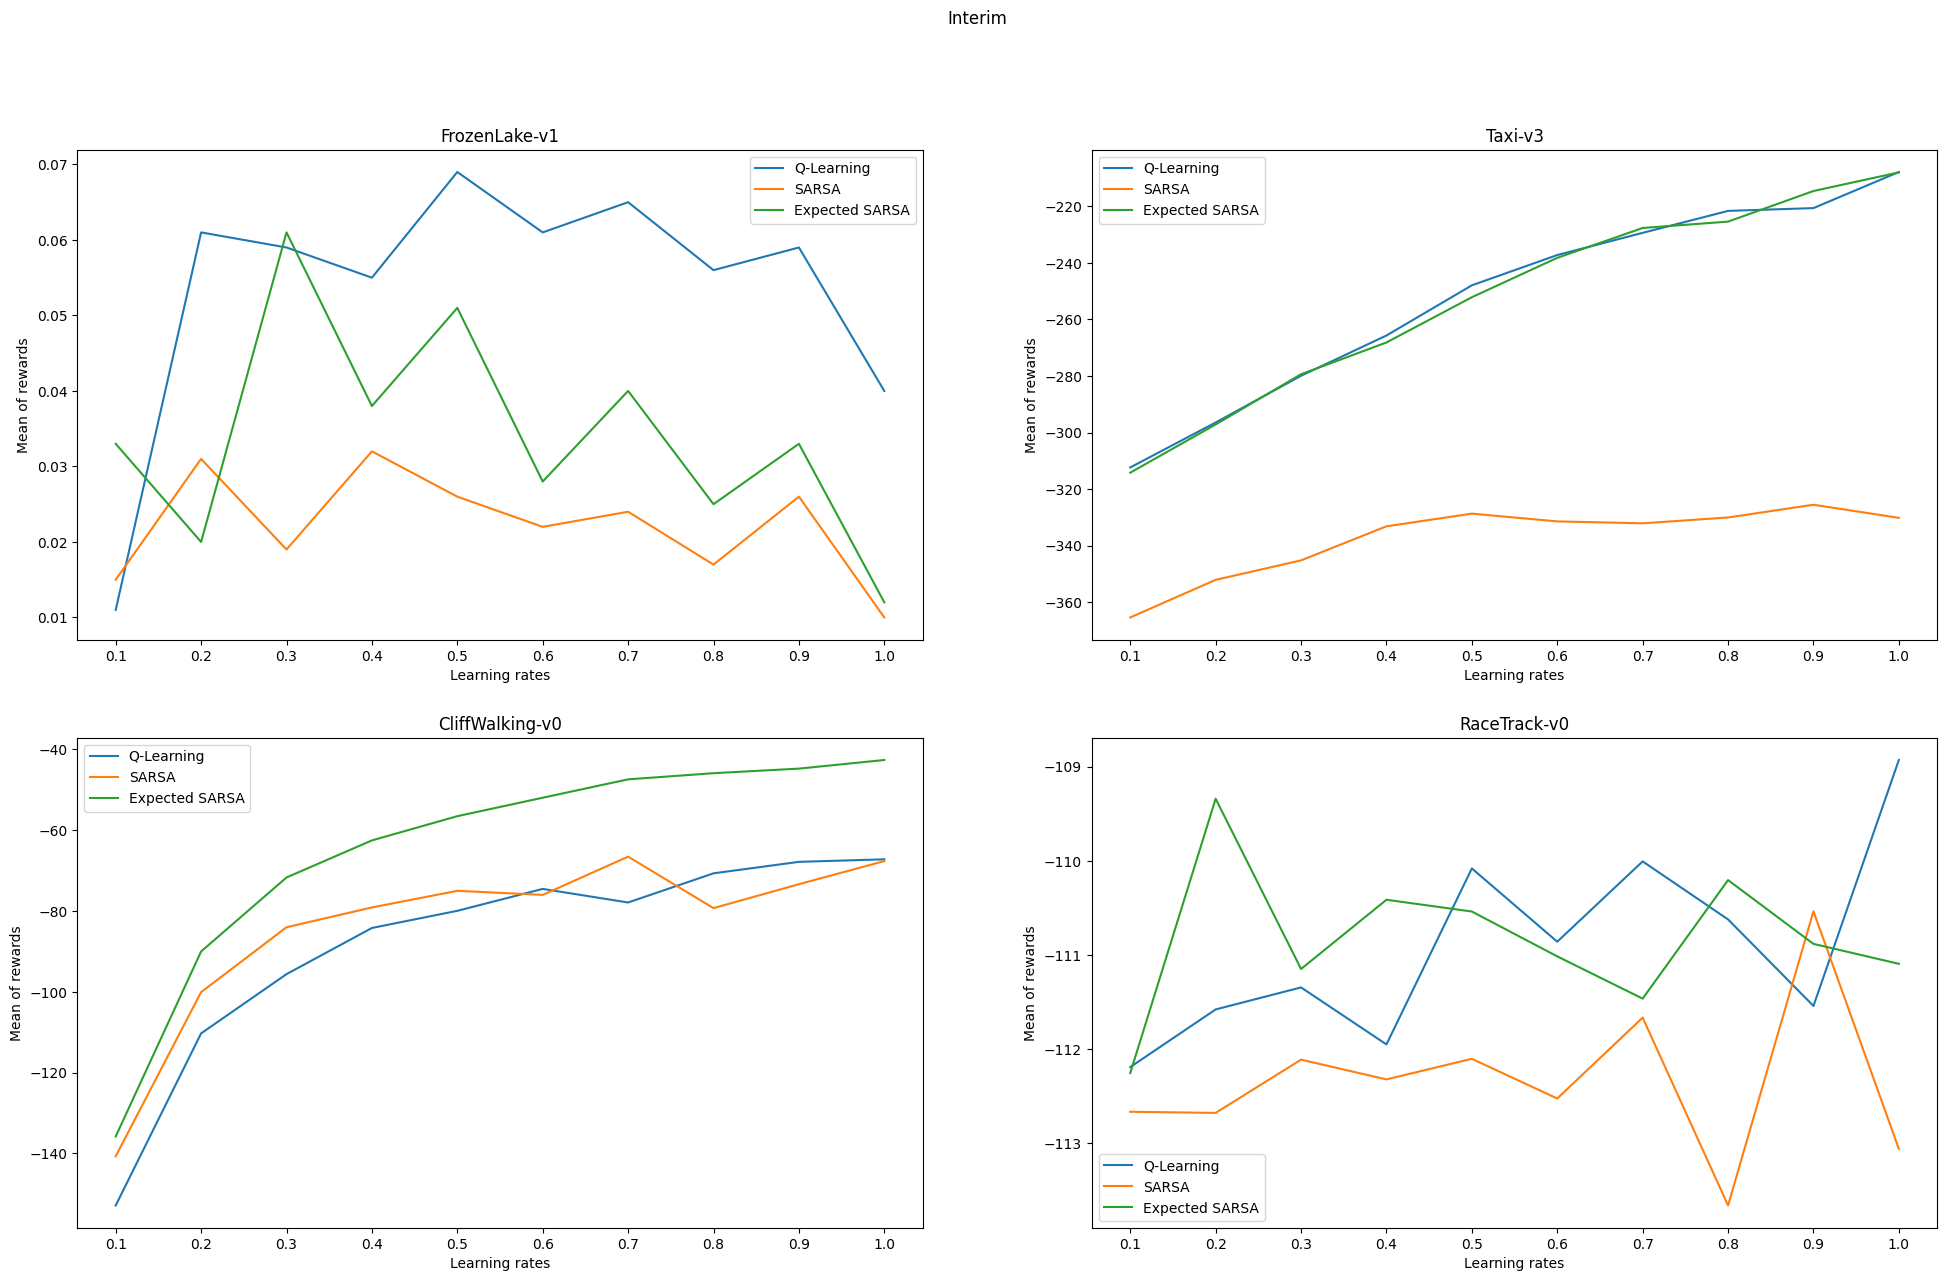

In [ ]:
plot_results("Interim", environments, learning_rates, {
    "Q-Learning": qlearning_interim,
    "SARSA": sarsa_interim,
    "Expected SARSA": expected_sarsa_interim
  })

In [ ]:
for environment in environments:

  print("Environment: " + environment)

  qlearning_asymptotic[environment] = {}
  sarsa_asymptotic[environment] = {}
  expected_sarsa_asymptotic[environment] = {}

  for learning_rate in learning_rates:

      sum_rewards_per_run_qlearning = 0
      sum_rewards_per_run_sarsa = 0
      sum_rewards_per_run_expected_sarsa = 0

      for run in (progress_bar := tqdm(range(runs_asymptotic))):

          progress_bar.set_description("Learning rate: " + str(learning_rate) + " Runs: " + str(runs_asymptotic))

          rewards_per_episode, _ = run_qlearning(environments[environment], n_episodes_asymptotic, learning_rate)
          sum_rewards_per_run_qlearning += sum(rewards_per_episode) / len(rewards_per_episode)

          rewards_per_episode, _ = run_sarsa(environments[environment], n_episodes_asymptotic, learning_rate)
          sum_rewards_per_run_sarsa += sum(rewards_per_episode) / len(rewards_per_episode)

          rewards_per_episode, _ = run_expected_sarsa(environments[environment], n_episodes_asymptotic, learning_rate)
          sum_rewards_per_run_expected_sarsa += sum(rewards_per_episode) / len(rewards_per_episode)

      qlearning_asymptotic[environment][learning_rate] = sum_rewards_per_run_qlearning / runs_asymptotic
      sarsa_asymptotic[environment][learning_rate] = sum_rewards_per_run_sarsa / runs_asymptotic
      expected_sarsa_asymptotic[environment][learning_rate] = sum_rewards_per_run_expected_sarsa / runs_asymptotic

Environment: FrozenLake-v1


Learning rate: 1.0 Runs: 10: 100%|██████████| 10/10 [00:00<00:00, 43.14it/s]


Environment: Taxi-v3


Learning rate: 1.0 Runs: 10: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


Environment: CliffWalking-v0


Learning rate: 1.0 Runs: 10: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


Environment: RaceTrack-v0


Learning rate: 1.0 Runs: 10: 100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


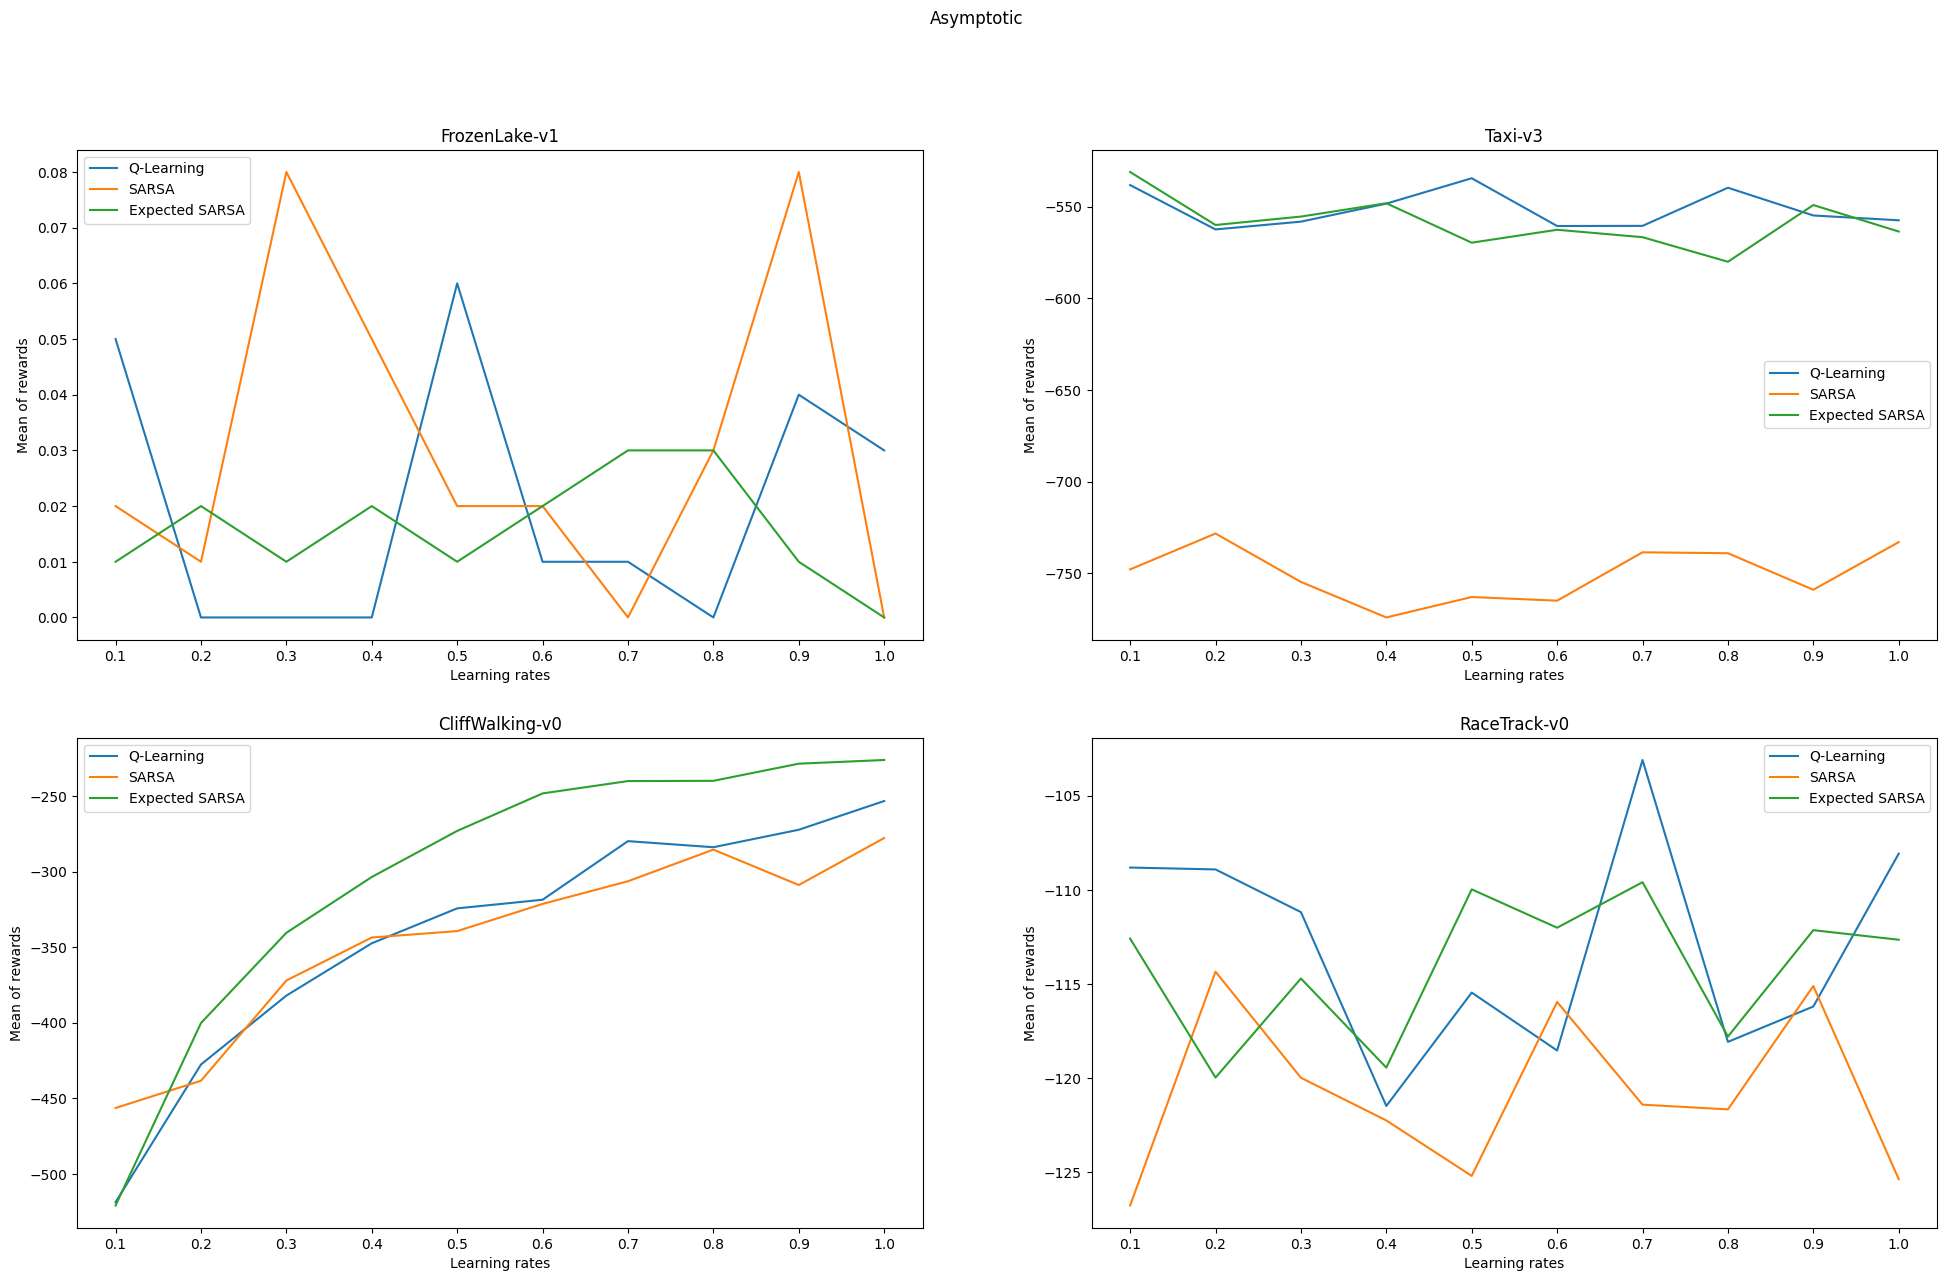

In [ ]:
plot_results("Asymptotic", environments, learning_rates, {
    "Q-Learning": qlearning_asymptotic,
    "SARSA": sarsa_asymptotic,
    "Expected SARSA": expected_sarsa_asymptotic
})